In [12]:
import os
os.chdir(r"C:\Users\ASUS\OneDrive\Desktop\UA")
print("New working directory:", os.getcwd())


New working directory: C:\Users\ASUS\OneDrive\Desktop\UA


In [16]:
import pandas as pd
import numpy as np

# Base folder path
data_path = r"C:\Users\ASUS\OneDrive\Desktop\UA\\"

# Load datasets
airports = pd.read_csv(data_path + "Airports Data.csv")
bags = pd.read_csv(data_path + "Bag Level Data.csv")
flights = pd.read_csv(data_path + "Flight Level Data.csv")
pnr_flight = pd.read_csv(data_path + "PNR Flight Level Data.csv")
pnr_remark = pd.read_csv(data_path + "PNR Remark Level Data.csv")

# Quick confirmation
print("Datasets loaded successfully!")
print("Airports shape:", airports.shape)
print("Bags shape:", bags.shape)
print("Flights shape:", flights.shape)
print("PNR_Flight shape:", pnr_flight.shape)
print("PNR_Remark shape:", pnr_remark.shape)


Datasets loaded successfully!
Airports shape: (5612, 2)
Bags shape: (687245, 8)
Flights shape: (8099, 15)
PNR_Flight shape: (687878, 12)
PNR_Remark shape: (51698, 4)


In [18]:
# --- Quick overview function ---
def quick_overview(df, name):
    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Missing values (top 5):\n", df.isnull().sum().head())
    print("Sample rows:\n", df.head(3))

datasets = {
    "Airports": airports,
    "Bags": bags,
    "Flights": flights,
    "PNR_Flight": pnr_flight,
    "PNR_Remark": pnr_remark
}

for name, df in datasets.items():
    quick_overview(df, name)

# --- Convert datetime columns in Flights ---
flights['scheduled_departure_datetime_local'] = pd.to_datetime(flights['scheduled_departure_datetime_local'])
flights['actual_departure_datetime_local'] = pd.to_datetime(flights['actual_departure_datetime_local'])

# --- Calculate flight delays in minutes ---
flights['Delay_minutes'] = (
    flights['actual_departure_datetime_local'] - flights['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# --- Basic flight delay metrics ---
avg_delay = flights['Delay_minutes'].mean()
delayed_percentage = (flights['Delay_minutes'] > 0).mean() * 100

print(f"Average delay (minutes): {avg_delay:.2f}")
print(f"Percentage of flights delayed: {delayed_percentage:.2f}%")



===== Airports =====
Shape: (5612, 2)
Columns: ['airport_iata_code', 'iso_country_code']
Missing values (top 5):
 airport_iata_code     0
iso_country_code     15
dtype: int64
Sample rows:
   airport_iata_code iso_country_code
0               DAU               PG
1               MDU               PG
2               MXH               PG

===== Bags =====
Shape: (687245, 8)
Columns: ['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'bag_tag_unique_number', 'bag_tag_issue_date', 'bag_type']
Missing values (top 5):
 company_id                          0
flight_number                       0
scheduled_departure_date_local      0
scheduled_departure_station_code    0
scheduled_arrival_station_code      0
dtype: int64
Sample rows:
   company_id  flight_number scheduled_departure_date_local  \
0         UA           1068                     2025-08-01   
1         UA            622                     2025-08

In [19]:
# Total passengers per flight
pax_counts = pnr_flight.groupby(['flight_number', 'scheduled_departure_date_local'])['total_pax'].sum().reset_index()
pax_counts.rename(columns={'total_pax': 'total_passengers'}, inplace=True)

# Merge with flights
master_df = flights.merge(
    pax_counts, 
    how='left', 
    on=['flight_number','scheduled_departure_date_local']
)


In [20]:
# Count bags per type per flight
bag_counts = bags.groupby(['flight_number', 'scheduled_departure_date_local', 'bag_type']).size().unstack(fill_value=0)

# Add ratio of Transfer to Checked bags
bag_counts['transfer_to_checked_ratio'] = bag_counts.get('Transfer', 0) / bag_counts.get('Checked', 1)

# Reset index for merging
bag_counts = bag_counts.reset_index()

# Merge with master_df
master_df = master_df.merge(bag_counts, how='left', on=['flight_number','scheduled_departure_date_local'])


In [21]:
# Count SSRs per flight
ssr_counts = pnr_remark.groupby(['flight_number', 'pnr_creation_date']).size().reset_index(name='ssr_count')

# Merge with master_df
master_df = master_df.merge(
    ssr_counts, 
    how='left', 
    left_on=['flight_number','scheduled_departure_date_local'], 
    right_on=['flight_number','pnr_creation_date']
)

# Drop 'pnr_creation_date' column
master_df.drop(columns=['pnr_creation_date'], inplace=True)


In [22]:
# Ground time tightness
master_df['tight_ground_time'] = master_df['scheduled_ground_time_minutes'] <= master_df['minimum_turn_minutes']

# High passenger load flag (e.g., above 90th percentile)
pax_90th = master_df['total_passengers'].quantile(0.9)
master_df['high_passenger_load'] = master_df['total_passengers'] > pax_90th

# Fill missing SSRs and bag ratios with 0
master_df['ssr_count'] = master_df['ssr_count'].fillna(0)
master_df['transfer_to_checked_ratio'] = master_df['transfer_to_checked_ratio'].fillna(0)


In [23]:
# Normalize numeric features to 0-1 range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

master_df[['Delay_norm', 'ssr_norm', 'bag_ratio_norm', 'passenger_load_norm']] = scaler.fit_transform(
    master_df[['Delay_minutes', 'ssr_count', 'transfer_to_checked_ratio', 'total_passengers']]
)

# Encode boolean features as 0/1
master_df['tight_ground_time_flag'] = master_df['tight_ground_time'].astype(int)
master_df['high_passenger_load_flag'] = master_df['high_passenger_load'].astype(int)

# Compute Flight Difficulty Score (weights can be adjusted)
master_df['Flight_Difficulty_Score'] = (
    0.3 * master_df['Delay_norm'] +
    0.2 * master_df['ssr_norm'] +
    0.2 * master_df['bag_ratio_norm'] +
    0.2 * master_df['passenger_load_norm'] +
    0.1 * master_df['tight_ground_time_flag']
)


In [24]:
# Rank flights within each day
master_df['daily_rank'] = master_df.groupby('scheduled_departure_date_local')['Flight_Difficulty_Score'] \
                                   .rank(method='first', ascending=False)

# Classify top 20% as Difficult, middle 60% as Medium, bottom 20% as Easy
def classify(rank, total):
    if rank <= 0.2 * total:
        return 'Difficult'
    elif rank <= 0.8 * total:
        return 'Medium'
    else:
        return 'Easy'

master_df['difficulty_category'] = master_df.groupby('scheduled_departure_date_local')['daily_rank'] \
                                             .transform(lambda x: x.rank(pct=True)) \
                                             .apply(lambda x: 'Difficult' if x <= 0.2 else ('Easy' if x > 0.8 else 'Medium'))


In [25]:
master_df[['flight_number','scheduled_departure_date_local','Flight_Difficulty_Score','difficulty_category']].head(10)


,flight_number,scheduled_departure_date_local,Flight_Difficulty_Score,difficulty_category
0,4792,2025-08-04,0.041921,Easy
1,920,2025-08-03,0.118437,Medium
2,1776,2025-08-10,0.148247,Difficult
3,5790,2025-08-06,0.077988,Medium
4,1398,2025-08-05,0.083389,Medium
5,5470,2025-08-07,0.043480,Easy
6,374,2025-08-15,0.094780,Medium
7,1577,2025-08-15,0.140269,Difficult
8,881,2025-08-03,0.350131,Difficult
9,2006,2025-08-09,0.111757,Medium


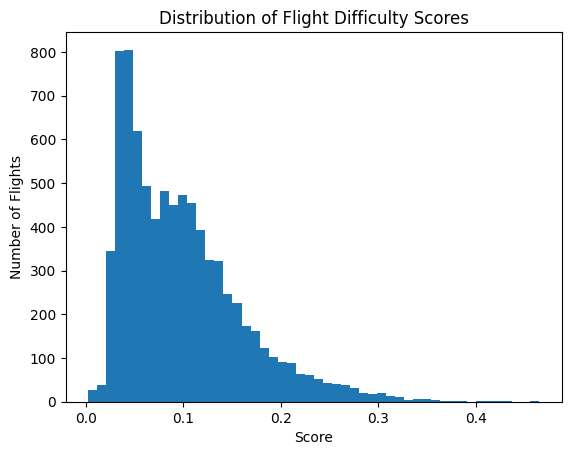

In [26]:
# Count of flights per category
master_df['difficulty_category'].value_counts()

# Histogram of scores
import matplotlib.pyplot as plt
plt.hist(master_df['Flight_Difficulty_Score'], bins=50)
plt.title("Distribution of Flight Difficulty Scores")
plt.xlabel("Score")
plt.ylabel("Number of Flights")
plt.show()


In [27]:
top_difficult = master_df[master_df['difficulty_category']=='Difficult'].sort_values(['scheduled_departure_date_local','Flight_Difficulty_Score'], ascending=[True,False])
top_difficult.head(10)


,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,high_passenger_load,Delay_norm,ssr_norm,bag_ratio_norm,passenger_load_norm,tight_ground_time_flag,high_passenger_load_flag,Flight_Difficulty_Score,daily_rank,difficulty_category
6984,UA,972,2025-08-01,ORD,BRU,2025-08-01 17:50:00+00:00,2025-08-02T08:50:00Z,2025-08-01 20:23:00+00:00,2025-08-02T10:50:00Z,318,...,True,0.164410,0.111111,0.788571,0.671727,0,1,0.363605,1.0,Difficult
6578,UA,1811,2025-08-01,ORD,MSP,2025-08-01 12:45:00+00:00,2025-08-01T14:28:00Z,2025-08-01 13:39:00+00:00,2025-08-01T15:01:00Z,166,...,False,0.068665,0.333333,0.334286,0.375712,1,0,0.329266,2.0,Difficult
1842,UA,1363,2025-08-01,ORD,LAX,2025-08-01 12:54:00+00:00,2025-08-01T15:23:00Z,2025-08-01 13:16:00+00:00,2025-08-01T15:51:00Z,200,...,True,0.037718,0.555556,0.080000,0.451613,1,1,0.328749,3.0,Difficult
2925,UA,2182,2025-08-01,ORD,PHL,2025-08-01 11:20:00+00:00,2025-08-01T14:29:00Z,2025-08-01 11:42:00+00:00,2025-08-01T14:36:00Z,150,...,False,0.037718,0.666667,0.065714,0.351044,1,0,0.328000,4.0,Difficult
1680,UA,2207,2025-08-01,ORD,OMA,2025-08-01 15:58:00+00:00,2025-08-01T17:36:00Z,2025-08-01 16:27:00+00:00,2025-08-01T17:48:00Z,179,...,False,0.044487,0.333333,0.271429,0.387097,1,0,0.311718,5.0,Difficult
235,UA,845,2025-08-01,ORD,GRU,2025-08-01 21:20:00+00:00,2025-08-02T09:30:00Z,2025-08-01 21:36:00+00:00,2025-08-02T09:32:00Z,318,...,True,0.031915,0.222222,0.574286,0.690702,0,1,0.307016,6.0,Difficult
1830,UA,219,2025-08-01,ORD,HNL,2025-08-01 09:30:00+00:00,2025-08-01T13:30:00Z,2025-08-01 09:50:00+00:00,2025-08-01T13:42:00Z,318,...,True,0.035783,0.333333,0.337143,0.808349,0,1,0.306500,7.0,Difficult
7943,UA,881,2025-08-01,ORD,HND,2025-08-01 12:50:00+00:00,2025-08-02T15:55:00Z,2025-08-01 13:00:00+00:00,2025-08-02T15:47:00Z,318,...,True,0.026112,0.000000,0.748571,0.741935,0,1,0.305935,8.0,Difficult
7701,UA,944,2025-08-01,ORD,FRA,2025-08-01 15:10:00+00:00,2025-08-02T06:30:00Z,2025-08-01 16:40:00+00:00,2025-08-02T08:01:00Z,318,...,True,0.103482,0.000000,0.585714,0.751423,0,1,0.298472,9.0,Difficult
4010,UA,1584,2025-08-01,ORD,LAX,2025-08-01 10:50:00+00:00,2025-08-01T13:23:00Z,2025-08-01 12:06:00+00:00,2025-08-01T14:22:00Z,200,...,True,0.089942,0.222222,0.117143,0.485769,1,1,0.292009,10.0,Difficult


In [28]:
# Save master_df for next notebook
master_df.to_csv(r"C:\Users\ASUS\OneDrive\Desktop\UA\master_df.csv", index=False)
